<a href="https://colab.research.google.com/github/lijingwang/DataScienceForGeosciences/blob/main/hw2/Homework2_extreme_value_analysis_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science for the Geosciences, 2022
       
Author: Lijing Wang (lijing52@stanford.edu)


---


In [ ]:
## Clone data from our GitHub repository
! git clone https://github.com/lijingwang/DataScienceForGeosciences.git

fatal: destination path 'DataScienceForGeosciences' already exists and is not an empty directory.


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 18})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the diamond dataset

In [ ]:
# Load dataset
diamond_dataset = np.loadtxt('/content/DataScienceForGeosciences/hw2/diamond_dataset.txt')

# Exploratory data analysis using extreme value statistics

## Pareto quantile plot

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def pareto_quantile(data,title = None):    
    data = np.sort(data)[::-1]
    n = len(data)
    plt.scatter(-np.log10((np.arange(n)+1)/(n+1)),np.log10(data),s = 10, color = 'black')
    plt.xlabel('$-\log(i/(n+1))$')
    plt.ylabel('$\log(x_i^*)$')
    plt.title(title)

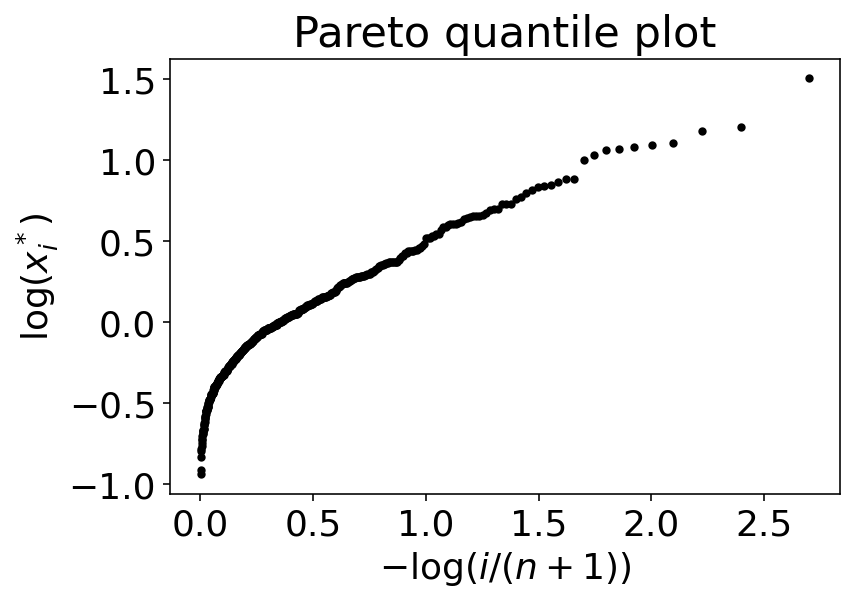

In [ ]:
pareto_quantile(diamond_dataset, title = 'Pareto quantile plot')

## Mean excess quantile plot

In [ ]:
def mean_excess_quantile(data):
    data = np.sort(data)[::-1]
    n = len(data)
    log_mean_excess = np.zeros(n)
    log_mean_excess[:] = np.nan
    for k in np.arange(1,len(data)):
        log_mean_excess[k] = np.log10(np.mean(data[:k]) - data[k])
    log_quantile = -np.log10((np.arange(n)+1)/(n+1))
    return log_mean_excess,log_quantile

Text(0.5, 1.0, 'Mean excess quantile plot')

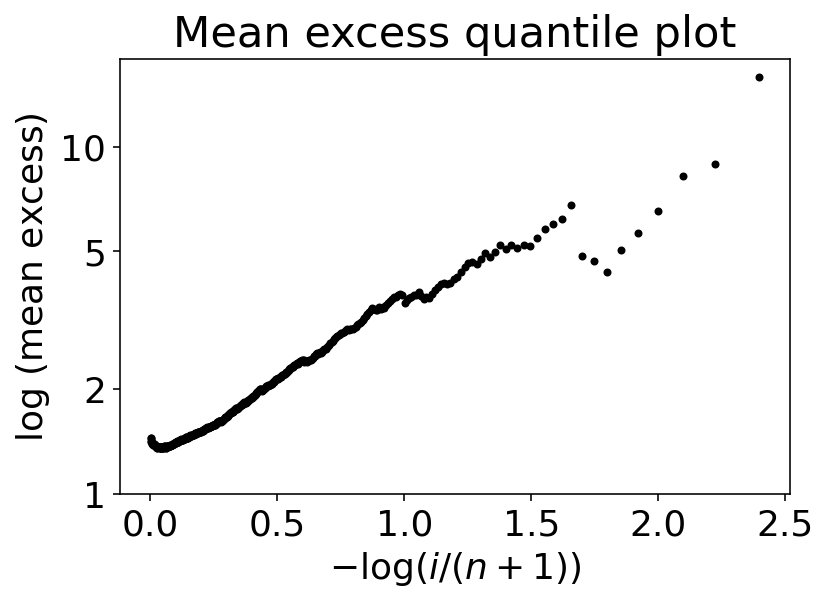

In [ ]:
log_mean_excess,log_quantile = mean_excess_quantile(diamond_dataset)
plt.plot(log_quantile,log_mean_excess,'.',color = 'black')
plt.xlabel('$-\log(i/(n+1))$')
plt.ylabel('$\log$ (mean excess)')
plt.yticks([ 0,np.log10(2),np.log10(5),1],[1,2,5,10])
plt.title('Mean excess quantile plot')

The slope of the tail for Pareto quantile plot/mean excess quantile plot indicates the extreme value index $\xi$.

# Fit GPD with threhold u

Here we just pick one value of $u$, you can choose your own one and see what is the difference between different choices

## Fit GPD and estimate $\xi$

Estimate $\xi$ first

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
data = diamond_dataset
data = np.sort(data)[::-1]

log_i_nplusone_threshold = 1
n = len(data)
X = -np.log10((np.arange(n)+1)/(n+1))
X = X.reshape(-1,1)
y = np.log10(data)
idx = np.int(np.where(X>log_i_nplusone_threshold)[0][-1])

Text(2.1, 0, '$\\hat{ξ}  = $0.58')

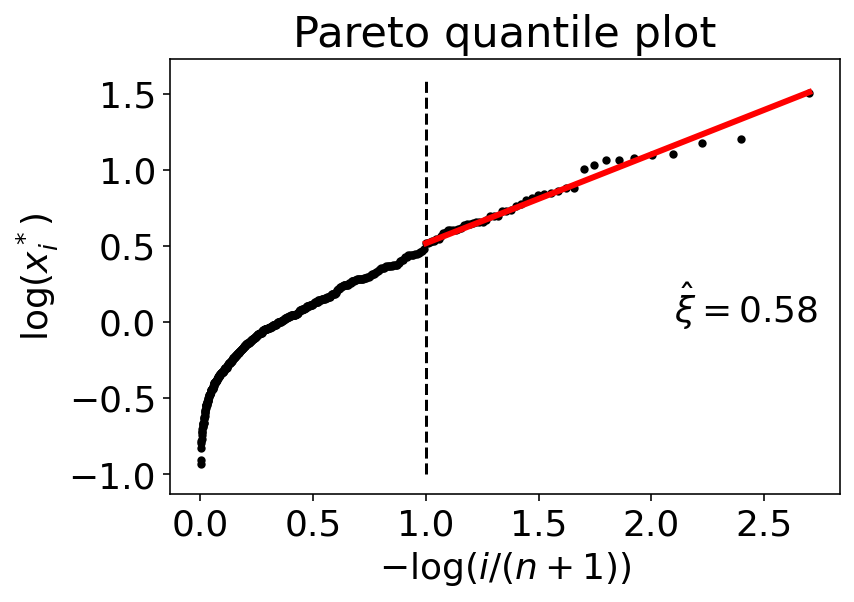

In [ ]:
reg = LinearRegression(fit_intercept = False).fit(X[:idx,:]-X[idx,:],y[:idx]-y[idx])
pareto_quantile(diamond_dataset, title = 'Pareto quantile plot')
plt.plot(X[:(idx+1),:],reg.predict(X[:(idx+1),:]-X[idx,:])+y[idx],'-',linewidth = 3,color = 'red')
plt.vlines(x = X[idx,:],ymin = -1,ymax = 1.6,linestyle = '--')
plt.text(2.1,0,'$\hat{\u03BE}  = $'+str(np.round(reg.coef_[0],2)))

Then estimate other parameters ($\mu, \sigma$) in GPD

In [ ]:
from scipy.stats import genpareto

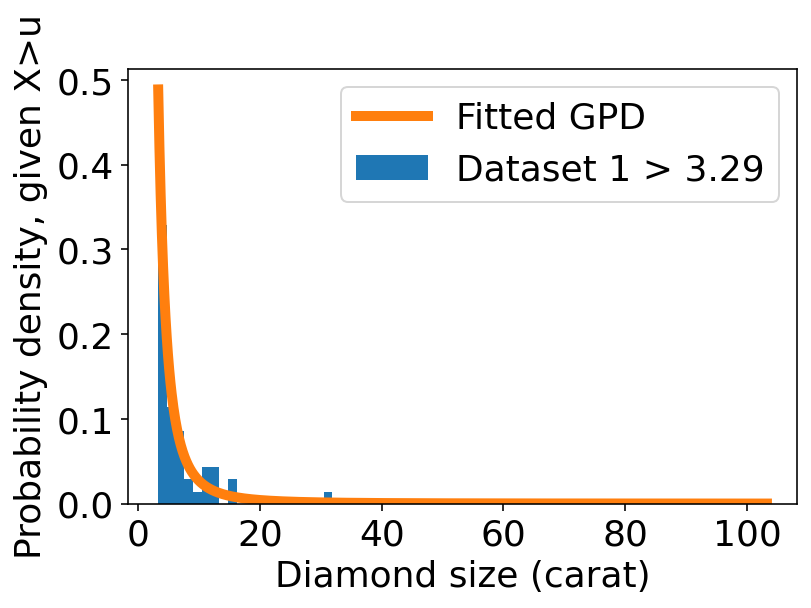

In [ ]:
fitted_xi = reg.coef_[0]
u = data[idx]
xi, mu, sigma = genpareto.fit(data[:idx]-u,fc = fitted_xi, floc = 0)

plt.hist(data[:idx], density  = True, label = 'Dataset 1 > '+str(np.round(u,2)),bins = 20)
plt.plot(np.linspace(u,100+u,1000),genpareto.pdf(np.linspace(0,100,1000), xi, mu, sigma),label = 'Fitted GPD',linewidth = 5)

plt.xlabel('Diamond size (carat)')
plt.ylabel('Probability density, given X>u')
plt.legend()

## Large diamonds (>40ct) in diamond deposits

In [ ]:
# P(X>40|X>u)
(1-genpareto.cdf(40-u, xi, mu, sigma))

# P(X>u)
np.mean(data>u)

# P(X>40) = P(X>40|X>u)*P(X>u)
p = (1-genpareto.cdf(40-u, xi, mu, sigma))*np.mean(data>u)

print('probability of observing a stone larger than 40ct: '+str(p))

probability of observing a stone larger than 40ct: 0.0015050485907338262
